<img style="float: left" src="images/spark.png" />
<img style="float: right" src="images/surfsara.png" />
<hr style="clear: both" />

## Airplane delays with Spark.ML and DataFrames

In this notebook we show how to work with DataFrames in Apache Spark's machine learning component Spark.ML. We'll be using part of the "Airline on-time performance" data set from Data expo 09, which you can find [here](http://stat-computing.org/dataexpo/2009/the-data.html) in full, together with a description of the records.

We are interested in the delays of flights and we will be trying to predict them by using the machine-learning model [Random Forests](https://en.wikipedia.org/wiki/Random_forest).

In [1]:
# Create a SparkSession, the 'DataFrame version' of the SparkContext
from pyspark.sql import SparkSession

spark = (
    SparkSession
    .builder
    .appName("Airplane delay prediction")
    .getOrCreate()
)


In [2]:
# Import a number of libraries we will be using
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook

In [3]:
dfAirplane = spark.read.parquet("data/airplane_2008.parquet")
dfAirplane.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)

### Inspecting the DataFrame

Let's see what our DataFrame contains by using [show](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.show).  We will print out the first 10 records of the DataFrame. If we specify no arguments to show, it will print out 20 records.

In [4]:
dfAirplane.head()

Row(Year=2008, Month=1, DayofMonth=3, DayOfWeek=4, DepTime=2003, CRSDepTime=1955, ArrTime=2211, CRSArrTime=2225, UniqueCarrier='WN', FlightNum=335, TailNum='N712SW', ActualElapsedTime=128, CRSElapsedTime=150, AirTime=116, ArrDelay=-14, DepDelay=8, Origin='IAD', Dest='TPA', Distance=810, TaxiIn=4, TaxiOut=8, Cancelled=0, CancellationCode=None, Diverted=0, CarrierDelay='NA', WeatherDelay='NA', NASDelay='NA', SecurityDelay='NA', LateAircraftDelay='NA')

Print the columns of the DataFrame. You may want to check the [DataFrame](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame) API documentation.

In [5]:
# TODO: Replace <FILL IN> with appropriate code

# Print the columns of this DataFrame
dfAirplane.columns

['Year',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'DepTime',
 'CRSDepTime',
 'ArrTime',
 'CRSArrTime',
 'UniqueCarrier',
 'FlightNum',
 'TailNum',
 'ActualElapsedTime',
 'CRSElapsedTime',
 'AirTime',
 'ArrDelay',
 'DepDelay',
 'Origin',
 'Dest',
 'Distance',
 'TaxiIn',
 'TaxiOut',
 'Cancelled',
 'CancellationCode',
 'Diverted',
 'CarrierDelay',
 'WeatherDelay',
 'NASDelay',
 'SecurityDelay',
 'LateAircraftDelay']

### Counting the records

Let's see how many records we have. Again, you may want to consult the [API docs](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame). 


In [6]:
# TODO: Replace <FILL IN> with appropriate code

# Print the number of records in this DataFrame
dfAirplane.count()

6855029

In [7]:
printSample = dfAirplane.head()
from IPython.display import display, HTML

th = ["<th>" + d + "</th>" for d in dfAirplane.columns]
td = ["<td>" + str(d) + "</td>" for d in printSample]

display(HTML("<table><thead><tr>" + "".join(th) + "</tr></thead><tbody><tr>" + "".join(td) + "</tr></tbody></table>"))

### Basic descriptive statistics

We are interested in the departure delay. We can compute the number of records that lists this field, together with the mean value, the standard deviation, the minimum and the maximum values, by invoking [describe](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.describe) on the column. 

In [8]:
dfAirplane.select(dfAirplane['DepDelay']).describe().show()

+-------+------------------+
|summary|          DepDelay|
+-------+------------------+
|  count|           6855029|
|   mean| 9.923844961122702|
| stddev|35.203863291550185|
|    min|              -534|
|    max|              2467|
+-------+------------------+



### Data reduction - Average department delay by month

In the next cell we compute the average departure delay per month. We do this by selecting the columns 'DepDelay' and 'Month', then group by 'Month' and compute the mean of 'DepDelay'.

The result of the [groupBy](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.groupBy) method is that for each month the values of 'DepDelay' are grouped together in a list. For each of these lists the mean is then computed.

Finally, we convert the DataFrame to a Python [pandas](http://pandas.pydata.org/) DataFrame. This means that we collect all data from the data frame to the driver. The pandas DataFrame (called `pdf` here) is local, it will not be distributed over many machines when using a cluster. We will visualize this Pandas DataFrame later, hence the import of matplotlib which is a visualisation library. 

In [9]:
grouped = dfAirplane[['DepDelay', 'Month']].groupby('Month').mean('DepDelay')

# The last line is equivalent to
# grouped = dfAirplane.select(dfAirplane['DepDelay'], dfAirplane['Month]).groupby('Month').mean('DepDelay')

grouped_sorted = grouped.sort(grouped['Month'])

pdf = grouped_sorted.toPandas()
pdf

Month  avg(DepDelay)
0       1      11.437988
1       2      13.638067
2       3      12.445089
3       4       8.167094
4       5       7.621402
5       6      13.567387
6       7      11.781284
7       8       9.572298
8       9       3.949296
9      10       3.778365
10     11       5.387065
11     12      17.147784

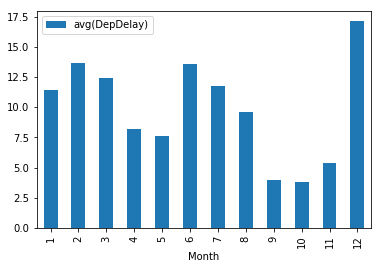

In [10]:
# The import of matplotlib is for the graphics
import matplotlib.pyplot as plt
# make sure the graphics are shown within the notebook
%matplotlib inline

pdf.plot(kind='bar', x='Month')

## What are the main causes for delay

Let's see what the main causes for delay are. Beacuse some fields have 'NA' values (Not Aavailable), we first filter these out. We then use an aggregation to sum ech of the fieldvalues that indicate causes for delay.  

In [34]:
from pyspark.sql.types import IntegerType

df = dfAirplane.filter(dfAirplane['WeatherDelay']!= 'NA').filter(dfAirplane['SecurityDelay'] != 'NA')\
.filter(dfAirplane['NASDelay'] != 'NA')

In [12]:
df.agg({"WeatherDelay" : "sum", "NASDelay": "sum", "SecurityDelay": "sum",\
                "LateAircraftDelay":"sum", "CarrierDelay" : "sum"}).toPandas().head()

sum(WeatherDelay)  sum(CarrierDelay)  sum(NASDelay)  \
0          4633717.0         24048217.0     26171501.0   

   sum(LateAircraftDelay)  sum(SecurityDelay)  
0              31670242.0            114316.0

## Visualisation of delay during the week

In [37]:
airline_df = df.withColumn('DepDelayed', airline_df['DepDelay']>15)

In [38]:
from pyspark.sql.functions import udf

# define hour function to obtain hour of day
def hour_ex(x): 
    h = int(str(int(x)).zfill(4)[:2])
    return h

# register as a UDF 
f = udf(hour_ex, IntegerType())

#CRSDepTime: scheduled departure time (local, hhmm)
airline_df = airline_df.withColumn('hour', f(airline_df.CRSDepTime))

In [39]:
#Origin_Airport="SJC"

In [40]:
#df_ORG = airline_df.filter(airline_df['origin']==Origin_Airport)
df_ORG = airline_df

In [45]:
hour_grouped = df_ORG.filter(df_ORG['DepDelayed']).select('DayOfWeek','hour','DepDelay')\
.groupby('DayOfWeek','hour').mean('DepDelay')
hour_grouped.show(30)

+---------+----+------------------+
|DayOfWeek|hour|     avg(DepDelay)|
+---------+----+------------------+
|        3|  22|62.814834024896264|
|        3|  15| 61.99744994333207|
|        7|  21| 66.31449012494961|
|        4|  10| 56.39341672152732|
|        5|  16| 68.82603513174404|
|        6|  20| 68.13662966700302|
|        1|   0| 66.62962962962963|
|        6|   1| 68.68085106382979|
|        3|   1| 62.36585365853659|
|        7|   4| 56.93333333333333|
|        2|   2| 76.18181818181819|
|        6|  22| 71.34520348837209|
|        3|  13|61.354958839670715|
|        7|  14| 70.98494459950943|
|        2|  19| 70.62968334541938|
|        3|  18| 69.46865810246092|
|        1|   7|  71.9017102417928|
|        4|   7| 68.79622099976082|
|        1|  20|  65.2582286704201|
|        7|   1| 80.18181818181819|
|        2|   3|              74.1|
|        6|  17| 69.67440676239943|
|        7|  20|  70.9025706940874|
|        1|   2| 72.58333333333333|
|        6|   0|58.053254437

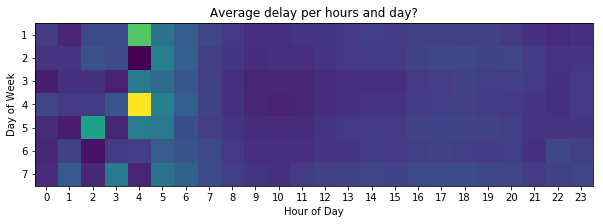

In [42]:
from pylab import rcParams
from IPython.display import display
from ipywidgets import interact

rcParams['figure.figsize'] = (10,5)
dh = hour_grouped.toPandas()
c = dh.pivot('DayOfWeek','hour')
X = c.columns.levels[1].values
Y = c.index.values
Z = c.values
plt.xticks(range(0,24), X)
plt.yticks(range(0,7), Y)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.title('Average delay per hours and day?')
plt.imshow(Z)

## Machine Learning - predicting delays with Random Forests

In the rest of this notebook we will build a simple model that can be used to predict departure delays for a given airport.

We will define a delay as a departure delay of more than 15 minutes. This new feature is categorical and binary: a flight is either delayed or not. Then we will (after some data munging) train a model using Random Forests. This model can then be used to predict delays, based on new observations.

Here we will not explain what Random Forests are. For more info you may want to refer to [this](https://www.youtube.com/watch?v=3kYujfDgmNk) video. If you are not familiair with decision trees you may want to see [this one first](https://www.youtube.com/watch?v=-dCtJjlEEgM).

In order to train and test the model we will divide the data into a training set and a test set. 

This exercise is to show you how to use Machine Learning in Apache Spark. Obviously, the model that we'll build is not very special. The aim is here to show principles.

Apache Spark has two machine learning libraries, one for RDDs (MLlib) and one for DataFrames (Spark.ML). The new developments will centre around Spark.ML. 

For those familair with Python's [scikit-learn](http://scikit-learn.org/): Spark.ML is very similar in design and also supports [Pipelines](http://spark.apache.org/docs/latest/ml-pipeline.html). However, we will not be covering those in this notebook. If you are interested in combining Spark and scikit-learn you may want to read [this blogpost](https://databricks.com/blog/2016/02/08/auto-scaling-scikit-learn-with-apache-spark.html) from the DataBricks blog.

### Predicting delays 

In the next step we will add an extra column to the dataframe which indicates whether a flight had a delay of more than 15 minutes or not. When so, we enter a value of 1.0 in the column 'label', otherwise we use '0.0'.

We will try to predict the value of this 'label' column by using Random Forests later. 

In the next cell we use [withColumn](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.withColumn) to add an extra column to a DataFrame. Note that we do not 'change' or 'edit' an existing DataFrame but that we create a new one. Remember that DataFrames are immutable.

The [when](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.when) condition, together with 'otherwise', functions like an if-then-else statement.

In [19]:
from pyspark.sql.functions import when

OrdDelayeddf = airline_df.withColumn('label', when(airline_df['DepDelay'] > 15, 1.0).otherwise(0.0))
Slimdf = OrdDelayeddf.select(['Month','DayofMonth', 'DayOfWeek', 'Distance', 'UniqueCarrier', 'Dest','label'])
Slimdf.show()

+-----+----------+---------+--------+-------------+----+-----+
|Month|DayofMonth|DayOfWeek|Distance|UniqueCarrier|Dest|label|
+-----+----------+---------+--------+-------------+----+-----+
|    1|         3|        4|     515|           WN| BWI|  1.0|
|    1|         3|        4|    1591|           WN| LAS|  1.0|
|    1|         3|        4|     828|           WN| MCO|  1.0|
|    1|         3|        4|    1489|           WN| PHX|  1.0|
|    1|         3|        4|     838|           WN| TPA|  1.0|
|    1|         3|        4|     220|           WN| BWI|  1.0|
|    1|         3|        4|     220|           WN| BWI|  1.0|
|    1|         3|        4|    1093|           WN| FLL|  1.0|
|    1|         3|        4|     972|           WN| MCO|  1.0|
|    1|         3|        4|     765|           WN| MDW|  1.0|
|    1|         3|        4|    1052|           WN| PBI|  1.0|
|    1|         3|        4|     888|           WN| BWI|  0.0|
|    1|         3|        4|     359|           WN| HOU

### Dealing with categorical variables - using StringIndexer

The feature (or column) 'UniqueCarrier' is a categorical feature. Our Random Forest Classifier requires that we map the values of a categorical feature to numbers. Spark.ML offers a function called [StringIndexer](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.StringIndexer) that does exactly this.

Let's see how it works in a toy example first.

In the next cell we create a DataFrame called `mldf`. It has two columns, that we name 'id' and 'category'. Next we transform the `mldf` DataFrame into a new DataFrame called 'index' by using a StringIndexer. The StringIndexer is given the input and an output column and then transforms the 'mldf' DataFrame. Run the cell and see if you understand what happens.

In [20]:
from pyspark.ml.feature import StringIndexer

mldf = spark.createDataFrame(
    [(0, "a"), (1, "b"), (2, "c"), (3, "a"), (4, "a"), (5, "c")],
    ["id", "category"])
indexer = StringIndexer(inputCol="category", outputCol="categoryIndex")
indexed = indexer.fit(mldf).transform(mldf)
indexed.show()

+---+--------+-------------+
| id|category|categoryIndex|
+---+--------+-------------+
|  0|       a|          0.0|
|  1|       b|          2.0|
|  2|       c|          1.0|
|  3|       a|          0.0|
|  4|       a|          0.0|
|  5|       c|          1.0|
+---+--------+-------------+



### Using StringIndexer to transform 'UniqueCarrier'

Next, use StringIndexer yourself to transform 'UniqueCarrier'. As name of the output column use 'Carrier'! We will be using this name later on. 

In [21]:
# TODO: Replace <FILL IN> with appropriate code
stringIndexer = StringIndexer(inputCol ="UniqueCarrier", outputCol="Carrier")

si_model = stringIndexer.fit(OrdDelayeddf)
si_df = si_model.transform(Slimdf)
si_df.show()

+-----+----------+---------+--------+-------------+----+-----+-------+
|Month|DayofMonth|DayOfWeek|Distance|UniqueCarrier|Dest|label|Carrier|
+-----+----------+---------+--------+-------------+----+-----+-------+
|    1|         3|        4|     515|           WN| BWI|  1.0|    0.0|
|    1|         3|        4|    1591|           WN| LAS|  1.0|    0.0|
|    1|         3|        4|     828|           WN| MCO|  1.0|    0.0|
|    1|         3|        4|    1489|           WN| PHX|  1.0|    0.0|
|    1|         3|        4|     838|           WN| TPA|  1.0|    0.0|
|    1|         3|        4|     220|           WN| BWI|  1.0|    0.0|
|    1|         3|        4|     220|           WN| BWI|  1.0|    0.0|
|    1|         3|        4|    1093|           WN| FLL|  1.0|    0.0|
|    1|         3|        4|     972|           WN| MCO|  1.0|    0.0|
|    1|         3|        4|     765|           WN| MDW|  1.0|    0.0|
|    1|         3|        4|    1052|           WN| PBI|  1.0|    0.0|
|    1

### Transforming the 'Dest' column

We will do the same for the 'Dest' column.

In [22]:
stringIndexer = StringIndexer(inputCol='Dest', outputCol='Destination')
si_model = stringIndexer.fit(si_df)
dest_model_df = si_model.transform(si_df)

### Creating a feature vector: using VectorAssembler

All features that are used for building the classification model should be assembled in a feature vector. And again, Spark has a method for doing this: [VectorAssembler](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.VectorAssembler)

And again, let's see a toy example first.

First, we create a data frame with two rows and three columns, named 'a', 'b' and 'c'. Suppose now, that from this data frame we only want to use column 'a' and 'c' as features. Then we use only these columns as values for 'inputCols' in VectorAssembler. Note that the result of the transformation is a new DataFrame with an extra column called 'features'. This contains the features of the columns we selected, in the proper format.

In [23]:
from pyspark.ml.feature import VectorAssembler

mldf = spark.createDataFrame([(1, 0, 3), (2,3,2)], ["a", "b", "c"])
vecAssembler = VectorAssembler(inputCols=['a','c'], outputCol="features")
ass = vecAssembler.transform(mldf)
ass.show()

+---+---+---+---------+
|  a|  b|  c| features|
+---+---+---+---------+
|  1|  0|  3|[1.0,3.0]|
|  2|  3|  2|[2.0,2.0]|
+---+---+---+---------+



### Using a VectorAssembler
 
 In the cell below build the VectorAssembler that can be used to transform 'dest_model_df' in a data frame that cointains a column called 'features' (we reuse this name!). As input use the featureCols list.

In [24]:
# TODO: Replace <FILL IN> with appropriate code
featureCols = ['Month', 'DayofMonth', 'DayOfWeek', 'Distance', 'Carrier', 'Destination']

#set the input and output column names
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")

# return a dataframe with all of the  feature columns in  a vector column
features_df = assembler.transform(dest_model_df)
features_df.show()

+-----+----------+---------+--------+-------------+----+-----+-------+-----------+--------------------+
|Month|DayofMonth|DayOfWeek|Distance|UniqueCarrier|Dest|label|Carrier|Destination|            features|
+-----+----------+---------+--------+-------------+----+-----+-------+-----------+--------------------+
|    1|         3|        4|     515|           WN| BWI|  1.0|    0.0|       20.0|[1.0,3.0,4.0,515....|
|    1|         3|        4|    1591|           WN| LAS|  1.0|    0.0|        8.0|[1.0,3.0,4.0,1591...|
|    1|         3|        4|     828|           WN| MCO|  1.0|    0.0|       13.0|[1.0,3.0,4.0,828....|
|    1|         3|        4|    1489|           WN| PHX|  1.0|    0.0|       10.0|[1.0,3.0,4.0,1489...|
|    1|         3|        4|     838|           WN| TPA|  1.0|    0.0|       26.0|[1.0,3.0,4.0,838....|
|    1|         3|        4|     220|           WN| BWI|  1.0|    0.0|       20.0|[1.0,3.0,4.0,220....|
|    1|         3|        4|     220|           WN| BWI|  1.0|  

### Splitting the data set into a part for training and testing

Next, we split the data set into two parts. 80 percent of the data will be in the training set and the remaining 20 percent will be our test set. The assignment of records to these two sets is random. We use the [randomSplit](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.randomSplit) method that needs a list of weights and a seed for the random generation of the splits. 

In [25]:
train_data, test_data = features_df.randomSplit([0.8, 0.2], 12345)
train_data.show()

+-----+----------+---------+--------+-------------+----+-----+-------+-----------+--------------------+
|Month|DayofMonth|DayOfWeek|Distance|UniqueCarrier|Dest|label|Carrier|Destination|            features|
+-----+----------+---------+--------+-------------+----+-----+-------+-----------+--------------------+
|    1|         1|        2|      36|           OO| LAX|  1.0|    4.0|        5.0|[1.0,1.0,2.0,36.0...|
|    1|         1|        2|      36|           OO| SNA|  1.0|    4.0|       46.0|[1.0,1.0,2.0,36.0...|
|    1|         1|        2|      56|           9E| FNT|  1.0|   15.0|      103.0|[1.0,1.0,2.0,56.0...|
|    1|         1|        2|      56|           NW| DTW|  0.0|    8.0|       12.0|[1.0,1.0,2.0,56.0...|
|    1|         1|        2|      56|           NW| FNT|  1.0|    8.0|      103.0|[1.0,1.0,2.0,56.0...|
|    1|         1|        2|      56|           NW| FNT|  1.0|    8.0|      103.0|[1.0,1.0,2.0,56.0...|
|    1|         1|        2|      64|           OH| DAY|  1.0|  

### Training the Random Forest Classifier

Now we are ready to train the Random Forest Classifier. As input we have to provide a few things: the number of trees we want to create, the depth of each tree, the label column (the class we want to predict). In addition, we provide a seed for random generation and a maxBins number for categorical variables.

Spark ML offers ways to search for the optimal set of configuration parameters. See here: http://spark.apache.org/docs/latest/ml-tuning.html . Running these, can be quite slow in local mode.

So let's run the classifier with a limited number of trees, and with shallow depth. If we want to see the tree we can use the `toDebugString` method. The training may take a while.


In [26]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(numTrees=15, maxBins= 350, maxDepth=8, labelCol="label", seed=42)
model = rf.fit(train_data)

### Predictions on the test data

Let's use the model to make predictions on the test_data. Note, that by predicting we transform one data frame into another.

In [27]:
predictions = model.transform(test_data)
predictions.show()

+-----+----------+---------+--------+-------------+----+-----+-------+-----------+--------------------+--------------------+--------------------+----------+
|Month|DayofMonth|DayOfWeek|Distance|UniqueCarrier|Dest|label|Carrier|Destination|            features|       rawPrediction|         probability|prediction|
+-----+----------+---------+--------+-------------+----+-----+-------+-----------+--------------------+--------------------+--------------------+----------+
|    1|         1|        2|      56|           NW| DTW|  1.0|    8.0|       12.0|[1.0,1.0,2.0,56.0...|[10.4343580037954...|[0.41737432015181...|       1.0|
|    1|         1|        2|      64|           OH| CVG|  1.0|   13.0|       24.0|[1.0,1.0,2.0,64.0...|[8.65594229019490...|[0.34623769160779...|       1.0|
|    1|         1|        2|      64|           OH| DAY|  1.0|   13.0|       78.0|[1.0,1.0,2.0,64.0...|[8.47926202425950...|[0.33917048097038...|       1.0|
|    1|         1|        2|      67|           MQ| MKE|  

### Evaluating the results

So is machine learning that easy? Yes... but wait till we see how good the model performs.

We use Sparks [BinaryClassificationEvaluator](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.BinaryClassificationEvaluator) to get some information on how the model performs. In this case, we measure accuracy. Check, the documentation for more evaluation metrics.

In [28]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='label')
accuracy = evaluator.evaluate(predictions) 
accuracy

0.6592949237616045

### And now...

This is not really great but it's better than chance. We can tweak the model by training again, or we may choose other features, or add some more information to our features. For example, what about holidays? Or, if we can get weather data that could improve our model significantly. Maybe you want to look at other models for classification? The journey does not end here, but really has just begun.

But for now, we leave it at this. 